<a href="https://colab.research.google.com/github/phantomer-ai/AIFFEL_guest_cr/blob/main/Exploration/Quest04/Project_CIFAR10_image_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP1 작업환경 구성하기


In [15]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio.v2 as imageio
from IPython.display import Image, display


In [2]:
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

# STEP2 데이터셋 구성하기

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


(50000, 32, 32, 3)

In [4]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label'])
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label'])
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

# STEP3 생성자 모델구현하기

(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.


In [5]:
#1. 생성자 모델 함수 만들기

def make_generator_model():
    model = tf.keras.Sequential()

    # 입력: 100차원 노이즈 벡터
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))  # (8, 8, 256)

    # 업샘플링 1: (8, 8, 256) -> (16, 16, 128)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 업샘플링 2: (16, 16, 128) -> (32, 32, 64)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 출력 레이어: (32, 32, 64) -> (32, 32, 3)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

In [6]:
# 2. 핸덤 노이즈로 이미지 생성

# 생성자 모델 만들기
generator = make_generator_model()

# 랜덤 노이즈 생성
noise = tf.random.normal([1, 100])

# 이미지 생성
generated_image = generator(noise, training=False)

print("생성된 이미지 shape:", generated_image.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


생성된 이미지 shape: (1, 32, 32, 3)


# STEP4

(32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [7]:
# 판별자 모델 함수 구현


def make_discriminator_model():
    model = tf.keras.Sequential()

    # 입력: (32, 32, 3)
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 다운샘플링 1: (16, 16, 64)
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 평탄화 후 Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))  # 1차원 확률값

    return model

In [8]:
#판별자 모델로 생성이미지 판별

# 판별자 모델 만들기
discriminator = make_discriminator_model()

# 생성된 이미지 평가
decision = discriminator(generated_image)

print("판별 결과:", decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


판별 결과: tf.Tensor([[0.498984]], shape=(1, 1), dtype=float32)


# STEP5 손실함수와 최적화함수 구현하기

생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [9]:
#손실함수 정의

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

#판별자 손실함수
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # 진짜는 1로 판별해야 함
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # 가짜는 0으로 판별해야 함
    total_loss = real_loss + fake_loss
    return total_loss

#생성자 손실함수

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # 생성자는 판별자를 속이기 위해 1로 판별되게 유도

#판별 정확도 함수

def discriminator_accuracy(real_output, fake_output):
    real_pred = tf.cast(real_output > 0.5, tf.float32)  # 0.5보다 크면 진짜로 판별한 것
    fake_pred = tf.cast(fake_output < 0.5, tf.float32)  # 0.5보다 작으면 가짜로 판별한 것
    real_acc = tf.reduce_mean(real_pred)
    fake_acc = tf.reduce_mean(fake_pred)
    return (real_acc + fake_acc) / 2.0


#옵티 마이저 정의
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# STEP 6 훈련과정 상세 기능 구현하기
1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.


In [10]:

# 하이퍼파라미터
EPOCHS = 50
noise_dim = 100
BATCH_SIZE = 64
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# 기록용 딕셔너리
history = {'gen_loss': [], 'disc_loss': [], 'accuracy': []}

# 손실 함수
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 정확도 함수
def discriminator_accuracy(real_output, fake_output):
    real_pred = tf.cast(real_output > 0.5, tf.float32)
    fake_pred = tf.cast(fake_output < 0.5, tf.float32)
    real_acc = tf.reduce_mean(real_pred)
    fake_acc = tf.reduce_mean(fake_pred)
    return (real_acc + fake_acc) / 2.0

# 옵티마이저
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 1. 미니배치 훈련 함수
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        acc = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, acc

# 2. 시각화 함수 (고정된 seed로 생성 이미지 저장)
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        img = (predictions[i] + 1) / 2.0  # [-1,1] -> [0,1]
        plt.imshow(img)
        plt.axis('off')

    os.makedirs('generated_images', exist_ok=True)
    plt.savefig(f'generated_images/image_at_epoch_{epoch:04d}.png')
    plt.close()

# 3. 학습 이력 그래프 출력 함수
def draw_train_history(history):
    epochs = range(1, len(history['gen_loss']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['gen_loss'], label='Generator Loss')
    plt.plot(epochs, history['disc_loss'], label='Discriminator Loss')
    plt.legend()
    plt.title("Loss Over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['accuracy'], label='Discriminator Accuracy')
    plt.legend()
    plt.title("Discriminator Accuracy")

    plt.tight_layout()
    plt.show()

# 4. 체크포인트 저장 설정
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# STEP 7 학습 과정 진행하기
위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.
(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

In [11]:

import glob
import imageio
from IPython import display

# 학습 함수 정의
def train(dataset, epochs):
    for epoch in range(1, epochs + 1):
        print(f"[{epoch}/{epochs}] Epoch 시작")

        gen_loss_epoch = 0
        disc_loss_epoch = 0
        acc_epoch = 0
        step = 0

        for image_batch in dataset:
            gen_loss, disc_loss, acc = train_step(image_batch)

            gen_loss_epoch += gen_loss
            disc_loss_epoch += disc_loss
            acc_epoch += acc
            step += 1

        # 평균값 계산
        gen_loss_epoch /= step
        disc_loss_epoch /= step
        acc_epoch /= step

        # history 저장
        history['gen_loss'].append(gen_loss_epoch)
        history['disc_loss'].append(disc_loss_epoch)
        history['accuracy'].append(acc_epoch)

        print(f"Generator Loss: {gen_loss_epoch:.4f}, Discriminator Loss: {disc_loss_epoch:.4f}, Accuracy: {acc_epoch:.4f}")

        # 이미지 저장
        generate_and_save_images(generator, epoch, seed)

        # 체크포인트 저장 (매 5 에폭마다)
        if epoch % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    # 학습 후 히스토리 시각화
    draw_train_history(history)

In [12]:

#gif 로 과정 저장

def generate_gif():
    anim_file = 'dcgan.gif'

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = sorted(glob.glob('generated_images/image_at_epoch_*.png'))
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    print(f"GIF 저장 완료: {anim_file}")
    display(Image(filename=anim_file))

In [13]:
# 최신 체크포인트 불러오기
def load_latest_checkpoint():
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    if latest:
        checkpoint.restore(latest)
        print(f"체크포인트 로드 완료: {latest}")
    else:
        print("저장된 체크포인트가 없습니다.")

[1/50] Epoch 시작
Generator Loss: 1.0411, Discriminator Loss: 1.2141, Accuracy: 0.6804
[2/50] Epoch 시작
Generator Loss: 0.9829, Discriminator Loss: 1.2368, Accuracy: 0.6667
[3/50] Epoch 시작
Generator Loss: 1.1378, Discriminator Loss: 1.1554, Accuracy: 0.7080
[4/50] Epoch 시작
Generator Loss: 1.0230, Discriminator Loss: 1.2147, Accuracy: 0.6961
[5/50] Epoch 시작
Generator Loss: 0.9949, Discriminator Loss: 1.2034, Accuracy: 0.6940
[6/50] Epoch 시작
Generator Loss: 0.8966, Discriminator Loss: 1.2759, Accuracy: 0.6472
[7/50] Epoch 시작
Generator Loss: 0.8680, Discriminator Loss: 1.3232, Accuracy: 0.6315
[8/50] Epoch 시작
Generator Loss: 0.8783, Discriminator Loss: 1.3180, Accuracy: 0.6342
[9/50] Epoch 시작
Generator Loss: 0.8817, Discriminator Loss: 1.2740, Accuracy: 0.6467
[10/50] Epoch 시작
Generator Loss: 0.8983, Discriminator Loss: 1.2641, Accuracy: 0.6486
[11/50] Epoch 시작
Generator Loss: 1.0493, Discriminator Loss: 1.2130, Accuracy: 0.6818
[12/50] Epoch 시작
Generator Loss: 0.9255, Discriminator Loss: 1.

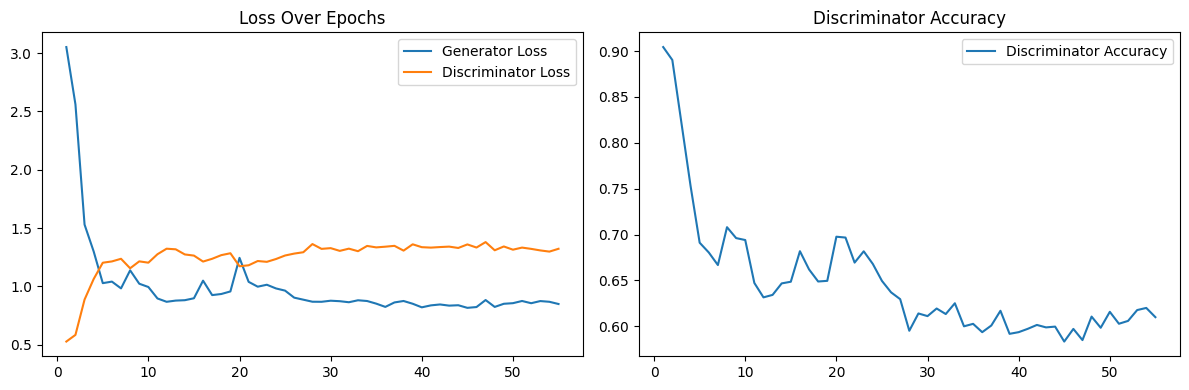

GIF 저장 완료: dcgan.gif


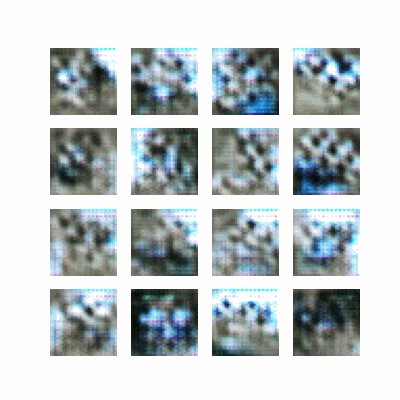

In [18]:
# 예시용 데이터셋 준비 (예: CIFAR-10 사용 시)
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5  # [-1, 1] 정규화
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(BATCH_SIZE)

# 학습 진행
train(train_dataset, 50)

# gif 생성
generate_gif()

# 필요 시 모델 불러오기
# load_latest_checkpoint()

GIF 저장 완료: dcgan.gif


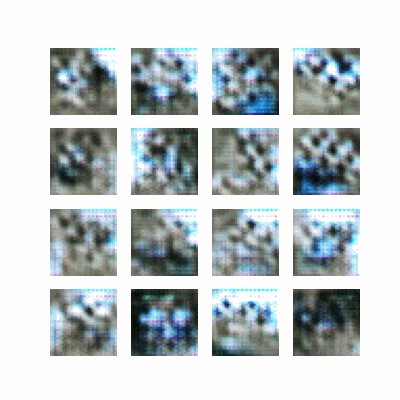

In [20]:
generate_gif()

# STEP 8 (optional) GAN 훈련 과정 개선하기
STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.
